The Section Below builds the basis for the program. It imports the necessary Python libraries and them reads the CSV file to populate a DataFrame.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# This dataset is originally over 6 million transactions. 
# This is a split subset of 500,000, for smaller file size.
df = pd.read_csv('transactions.csv', nrows=100000)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


The Section Below contains two charts. 

The first chart shows that fraudulent transactions are only of a specific 'type', either TRANSFER or CASH OUT.

The second pie charts shows the percentages of each 'type' of transactions.

Transfers and Cash Outs account for only a small percentage of all transactions with fraud representing only a tiny fraction of that. This either/or choice was the first step on my decision to choose Descision Trees/Random Forests as my model's classifier.

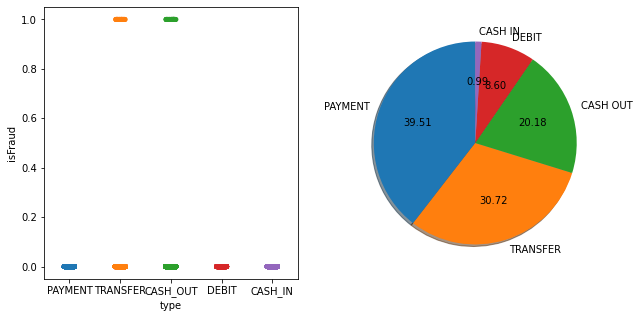

In [2]:
# Charts
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

sns.stripplot(x="type", y="isFraud", data=df, ax=axs[0])
plt.pie(df['type'].value_counts(), startangle=90, autopct='%.2f',labels=['PAYMENT', 'TRANSFER', 'CASH OUT', 'DEBIT', 'CASH IN'], shadow=True)
print()

The Section Below highlights a large correlation between the Old and New Balances of the original account and being flagged as Fraud .

It seems poeple commiting fraud tend to drain accounts they get access too. 

In [3]:
# Correlation with given value
df.corr().abs()[["newbalanceOrig"]]

,newbalanceOrig
step,0.003846
amount,0.017804
oldbalanceOrg,0.998846
newbalanceOrig,1.000000
oldbalanceDest,0.107784
newbalanceDest,0.073759
isFraud,0.010872
isFlaggedFraud,NaN


The Section Below covers my data modification and clean-up.
LabelEncoder() was needed for the 'type' String conversion to a float.
The dropped columns are the result of experimentation.
I would keep or remove columns and train the model with the same dataset. 
Removing more the destination account info kept the same accuracy_score but the recall (and F1) score dropped by almost 20%.

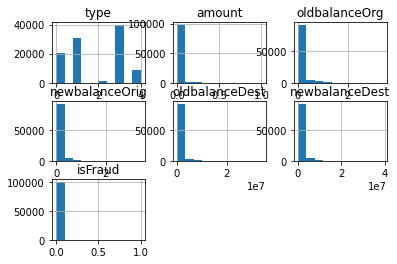

In [4]:
#Transformation and Data Modification

# Transforms Transaction 'type' string into float
le = LabelEncoder()
df.type = le.fit_transform(df.type)

# Name and Step columns would be too far down the decision tree. 
# The 'isFlaggedFraud' column is all 0s.

df.drop("nameOrig", axis=1, inplace=True)
df.drop("nameDest", axis=1, inplace=True)
df.drop("isFlaggedFraud", axis=1, inplace=True)
df.drop("step", axis=1, inplace=True)

# Graph of data after dropped columns.
df.hist()
plt.show()

The Section Below seperates the data into training and testing parts.

In [5]:
# Separating the target variable
X = df.values[:, :6]
y = df.values[:, 6]
  
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

The Section Below covers the creation of my model, its training, and scoring.

With the sample I used, I achieved a 99.92% accuracy score using sklearn.metrics.accuracy_score().

The other statistics show areas for improvement.
-Precision is acceptable but can be improved
-Recall is quite bad. Further refinement should be able to improve this.

Given the above:
    -The overall F1 Score of 0.56 is not good. Owing most of the problem to 'Recall'.

The Confusion Matrix simply gives the overall stats of precision and recall in a comparative fashion.

Accuracy score:  0.9992333333333333
Precision Score:  0.8235294117647058
Recall Score:  0.4117647058823529
F1 Score:  0.5490196078431372


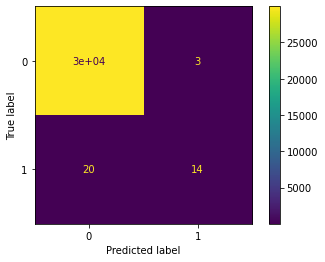

In [6]:
# My Model
my_RF_model = RandomForestClassifier() 

# Training Section
my_RF_model.fit(X_train, y_train)

# Testing Section
y_pred_RF = my_RF_model.predict(X_test)
print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred_RF))
print("Precision Score: ", metrics.precision_score(y_test, y_pred_RF))
print("Recall Score: ", metrics.recall_score(y_test, y_pred_RF))
print("F1 Score: ", metrics.f1_score(y_test, y_pred_RF))

cm = metrics.confusion_matrix(y_test, y_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The Section Below creates a function to take the needed arguments and return my model's prediction.

In [7]:
def predict_with_model(t_type, t_amount, t_OBO, t_NBO, t_OBD, t_NBD):
    # Cast all as float just to be sure.
    test_transaction = [float(t_type), float(t_amount), float(t_OBO), float(t_NBO), float(t_OBD), float(t_NBD)]
    result = int(my_RF_model.predict([test_transaction]))
    if result==0:
        return False
    elif result==1:
        return True
    else:
        print("Check the values entered.")

The Section Below prints a simple user experience to take in the needed variables and returns a prediction based on what was entered.

In [8]:
print("This model takes 6 variables as inputs.")
print("All Values need to be numerical.")
print("The first Value is a special case:")
print("(1 = CASH_OUT)")
print("(2 = DEBIT)")
print("(3 = PAYMENT)")
print("(4 = TRANSFER)")
print("(5 = CASH_IN)")


a = input("Enter the Transaction Type: ")
print("Transaction Type is:",a)
b = input("Enter the Transaction Amount: ")
print("Transaction Amount is:",b)
c = input("Enter the Original Account Balance Before Transaction: ")
print("Original Account Balance Before Transaction is:",c)
d = input("Enter the Original Account Balance After Transaction: ")
print("Original Account Balance After Transaction is:",d)
e = input("Enter the Destination Account Balance Before Transaction: ")
print("Destination Account Balance Before Transaction is:",e)
f = input("Enter the Destination Account Balance After Transaction: ")
print("Destination Account Balance After Transaction is:",f)

result = predict_with_model(a,b,c,d,e,f)
if result:
    print("\n\nMy Model Predicts this is Fraud!")
else:
    print("\n\nMy Model Predicts this is NOT Fraud.")

This model takes 6 variables as inputs.
All Values need to be numerical.
The first Value is a special case:
(1 = CASH_OUT)
(2 = DEBIT)
(3 = PAYMENT)
(4 = TRANSFER)
(5 = CASH_IN)
Transaction Type is: 1
Transaction Amount is: 1
Original Account Balance Before Transaction is: 1
Original Account Balance After Transaction is: 1
Destination Account Balance Before Transaction is: 1
Destination Account Balance After Transaction is: 1


My Model Predicts this is NOT Fraud.
